# Simple regression

In [1]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, fold_adaptation
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

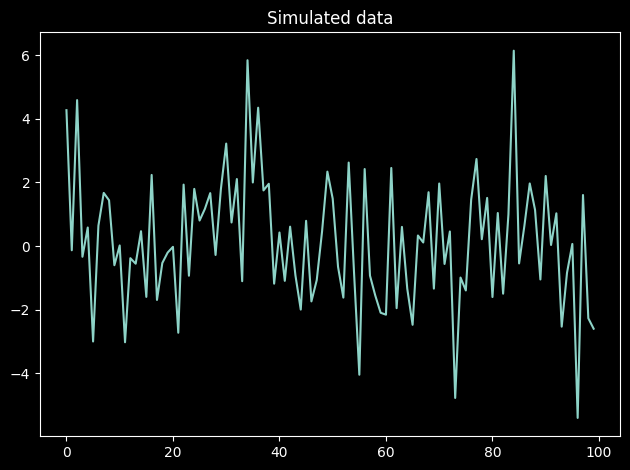

In [2]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [3]:
K = 10
logjoint_density, log_pred, make_initial_pos = reg.get_model(y, X, K=K)

In [4]:
# state, params = full_data_warmup(
#     prng_key=jax.random.PRNGKey(0),
#     logjoint_density=logjoint_density,
#     make_initial_pos=make_initial_pos,
#     num_chains=32,
#     batch_size=100,
#     warmup_iter=10000,
#     model_id=0,
#     prior_only=False
# )

In [5]:
# params

## CV


In [6]:
# state, params = cv_warmup(
#     prng_key=jax.random.PRNGKey(0),
#     logjoint_density=logjoint_density,
#     make_initial_pos=make_initial_pos,
#     num_folds=K,
#     num_chains=32,
#     batch_size=100,
#     warmup_iter=10000
# )

In [7]:
# params.keys()

In [8]:
# fig, axes = plt.subplots(1, 4, figsize=(10, 4))
# p_al, p_del, p_step, p_momentum = axes
# p_al.hist(params['alpha'])
# p_al.set_title('alpha')
# p_del.hist(params['delta'])
# p_del.set_title('delta')
# p_step.hist(params['step_size'])
# p_step.set_title('step_size')
# fig.tight_layout()

In [9]:
inference_key = jax.random.PRNGKey(43)
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       stoprule=make_positive_negative_rule(num_folds=K, level=0.95),
       num_folds=K,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50,
       ignore_stoprule=True
)

MEADS warmup for 10 folds per model (80 chains)...
Completed 80000 warmup iterations in 5 seconds
Starting cross-validation with 80 parallel GHMC chains...
Triggered stoprule after 7 batches in 15 seconds
  10.  A: -176.94 ±1.56 B: -179.84 ±1.73 Diff: 2.89 ±0.67 stop
  20.  A: -176.98 ±1.53 B: -179.89 ±1.72 Diff: 2.92 ±0.68 stop
  30.  A: -176.97 ±1.54 B: -179.86 ±1.72 Diff: 2.89 ±0.66 stop
  40.  A: -177.00 ±1.54 B: -179.83 ±1.73 Diff: 2.83 ±0.66 stop
Drew 400000 samples in 1 min 36 sec (4157 per sec)


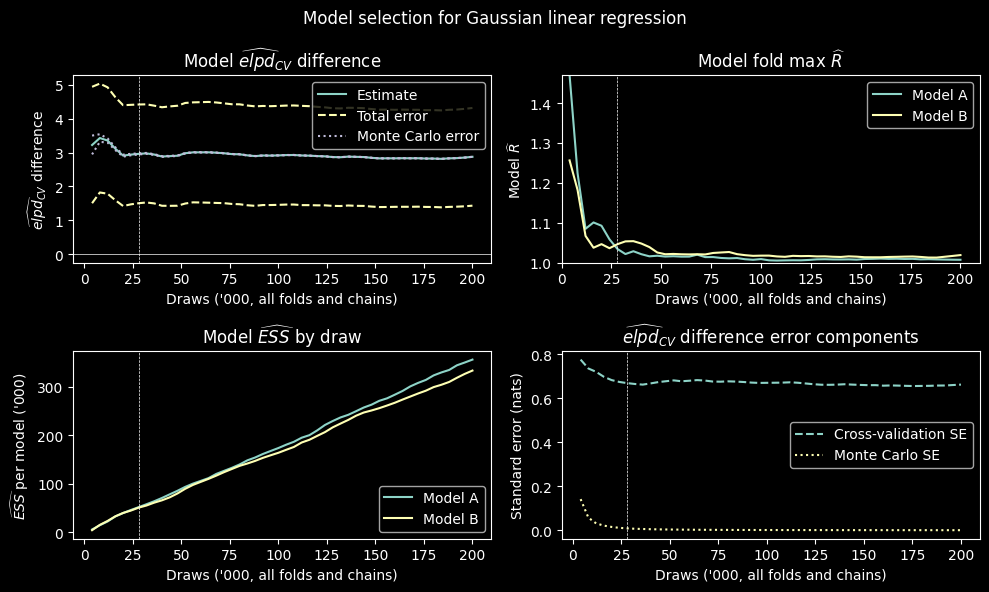

In [10]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

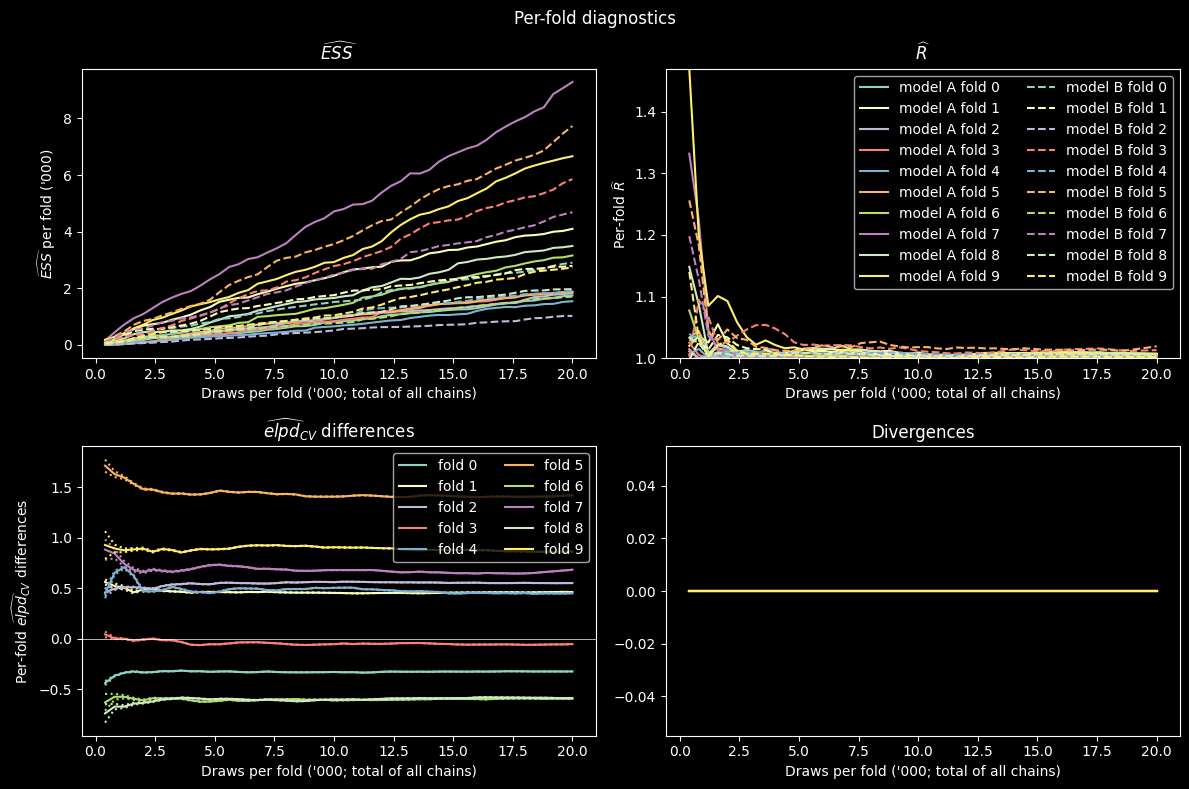

In [11]:
plot_fold_results(results, title='Per-fold diagnostics')

In [12]:
warmup_results = fold_adaptation(
    prng_key = jax.random.PRNGKey(0),
    logjoint_density = logjoint_density,
    make_initial_pos = make_initial_pos,
    num_models = 2,
    num_folds = 10,
    num_chains = 16,
    model_warmup_iter = 20_000,
    fold_warmup_iter = 10_000,
)

MEADS warmup for 2 model(s) (32 chains)...
Meads warmup done in 5.12 seconds. 
Step size: [0.41927725 0.406279  ] Alpha: [0.5619334  0.54439664] Delta: [0.2809667  0.27219832]
MEADS warmup for 10 folds per model (320 chains)...
MEADS warmup took 4.99 seconds


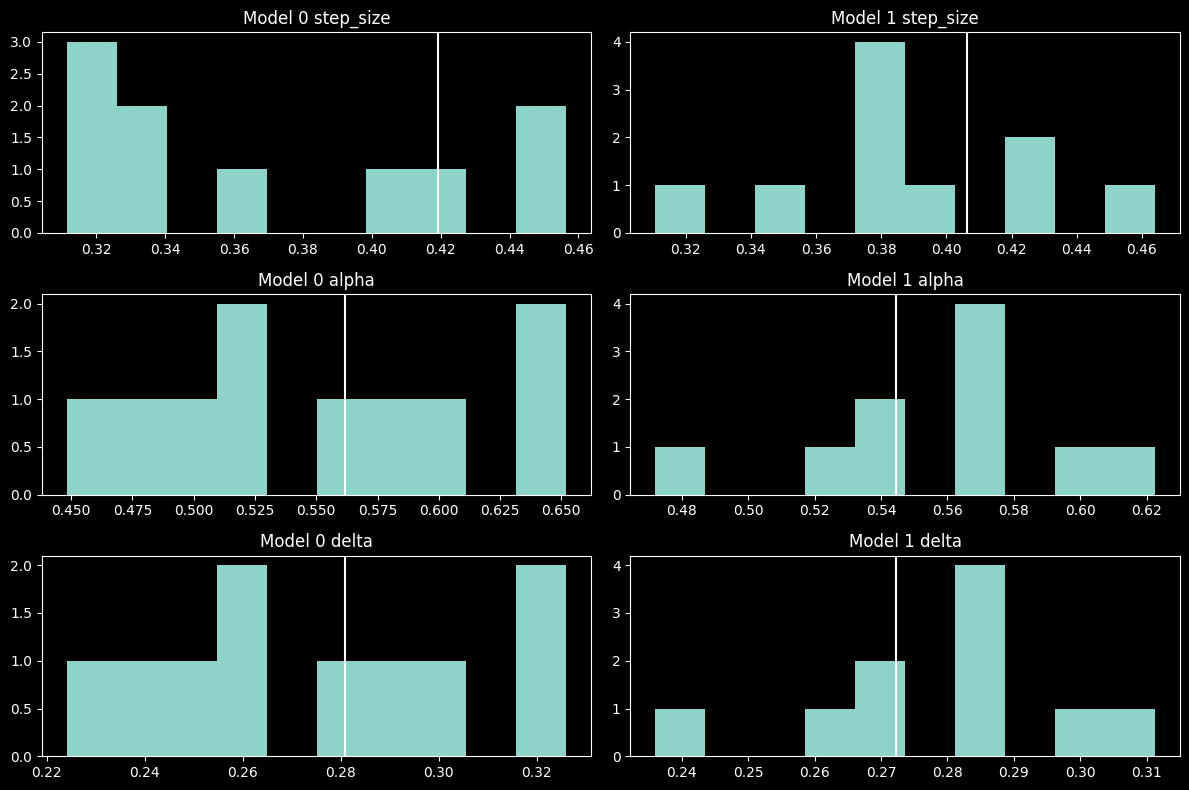

In [13]:
warmup_results.plot_dist()